In [3]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt

/Users/danielhey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Good ol' 9651065. A classic, well behaved PB1 system
kic_id = 9651065
times, mags = np.loadtxt(f"data/kic{kic_id}_lc.txt",usecols=(0,1)).T

# If you don't have the lightcurve data lying around, Maelstrom can instead download it from MAST:
# model = ms.Maelstrom.from_mast(kic_id)

## Spline fits

In [5]:
N = 1000
np.random.seed(42)
model = ms.InterpMaelstrom(times, mags, log_sigma2=0.0,
                        interp_x=np.linspace(times.min(), times.max(), N),
                        interp_y=1e-5*np.random.randn(N))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.090488
  Number of iterations: 14
  Number of functions evaluations: 22


Let's check the time delay variability. Weirdly enough, I've found that BFGS seems to be more efficient at optimizing the time delay over Adam. I've tried other gradient descent optimizers but none of them work as well

In [6]:
model.optimize([model.interp_y, model.log_sigma2])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -804144.141773
  Number of iterations: 76
  Number of functions evaluations: 92


Exhibit b:

In [7]:
np.random.seed(42)
adam_model = ms.InterpMaelstrom(times, mags, log_sigma2=0.0,
                        interp_x=np.linspace(times.min(), times.max(), N),
                        interp_y=1e-5*np.random.randn(N))

adam_model.adam_optimizer([model.interp_y, model.log_sigma2])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.090488
  Number of iterations: 14
  Number of functions evaluations: 22


100%|██████████| 1000/1000 [00:59<00:00, 16.93it/s, chi2=0]


The Adam optimiser actually shows more instability around regions with no data (spiky bits). In lieu of a terrible explanation from me, here's a nice Stackoverflow response: 

"One thing Adam does is maintain a rolling geometric mean of recent gradients and squares of the gradients. The squares of the gradients are used to divide (another rolling mean of) the current gradient to decide the current step. However, when your gradient becomes and stays very close to zero, this will make the squares of the gradient become so low that they either have large rounding errors or are effectively zero, which can introduce instability"

Text(0,0.5,'$\\tau (s)$')

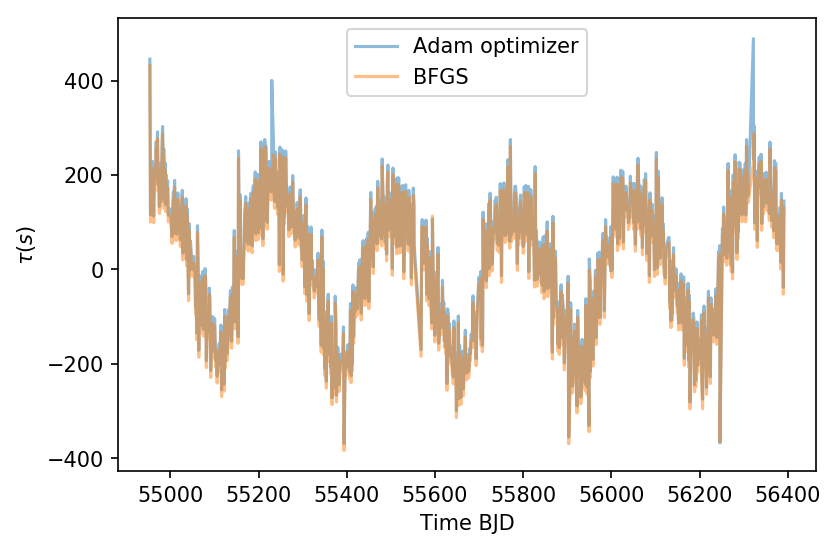

In [9]:
plt.plot(adam_model.time_data, adam_model.run(adam_model.tau)[:,0]*86400, alpha=0.5, label='Adam optimizer')
plt.plot(model.time_data, model.run(model.tau)[:,0]*86400, alpha=0.5, label='BFGS')

plt.legend()
plt.xlabel('Time BJD')
plt.ylabel(r'$\tau (s)$')

In [10]:
# Anyway, back to regular Maelstrom. I've linked it to your estimator so if no frequencies are supplied 
# it'll automatically find some

# Since we already have an InterpMaelstrom object with calculated frequencies, just turn it into a 
# regular Maelstrom object:
model = model.to_maelstrom()

# Otherwise:
# model = ms.Maelstrom(times, mags, etc)

In [11]:
# Set fit parameters to exclude the currently not working lighttime
model.params = [
    model.period,
    model.eccen_param,
    model.tref,
    model.varpi,
    model.log_sigma2
]

# Previously known values
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
orb_params = orbits[orbits.Name == f"kic{kic_id}"].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"] 
tp = orb_params["t_p"]
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1/86400.0

model.init_from_orbit(period=porb, lighttime=a1d, tref=tp, eccen=e, varpi=varpi)

# Some hacky crap to make the lighttime work with the fit for 9651065
#import tensorflow as tf
#model.run(tf.assign(model.lighttime,0.0021360710300925927 + tf.zeros_like(model.lighttime)))

In [12]:
model.run_warmup(samples=1000)

initial warm up: step_size: 1.6e-01; mean(accept_stat): 0.000:   3%|▎         | 3/100 [00:00<00:26,  3.71it/s]/Users/danielhey/anaconda3/lib/python3.6/site-packages/hemcee-0.0.0-py3.6.egg/hemcee/nuts.py:46: RuntimeWarning: overflow encountered in exp
initial warm up: step_size: 6.3e-03; mean(accept_stat): 0.474: 100%|██████████| 100/100 [03:14<00:00,  1.95s/it]
warm up 1/6: step_size: 2.1e-02; mean(accept_stat): 0.480: 100%|██████████| 25/25 [00:57<00:00,  2.30s/it]
warm up 2/6: step_size: 5.0e-03; mean(accept_stat): 0.439: 100%|██████████| 25/25 [00:40<00:00,  1.62s/it]
warm up 3/6: step_size: 8.1e-03; mean(accept_stat): 0.464: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]
warm up 4/6: step_size: 6.7e-03; mean(accept_stat): 0.473: 100%|██████████| 100/100 [03:39<00:00,  2.20s/it]
warm up 5/6: step_size: 8.2e-03; mean(accept_stat): 0.483: 100%|██████████| 200/200 [06:52<00:00,  2.06s/it]
warm up 6/6: step_size: 8.4e-03; mean(accept_stat): 0.485: 100%|██████████| 400/400 [16:06<00:00,

Warmup is arranged so that it replaces the tensors at the end of its run, like the scipy optimizer

In [13]:
model.run_mcmc(samples=1500)

step_size: 9.4e-03; mean(accept_stat): 0.648: 100%|██████████| 1500/1500 [1:26:54<00:00,  3.48s/it]


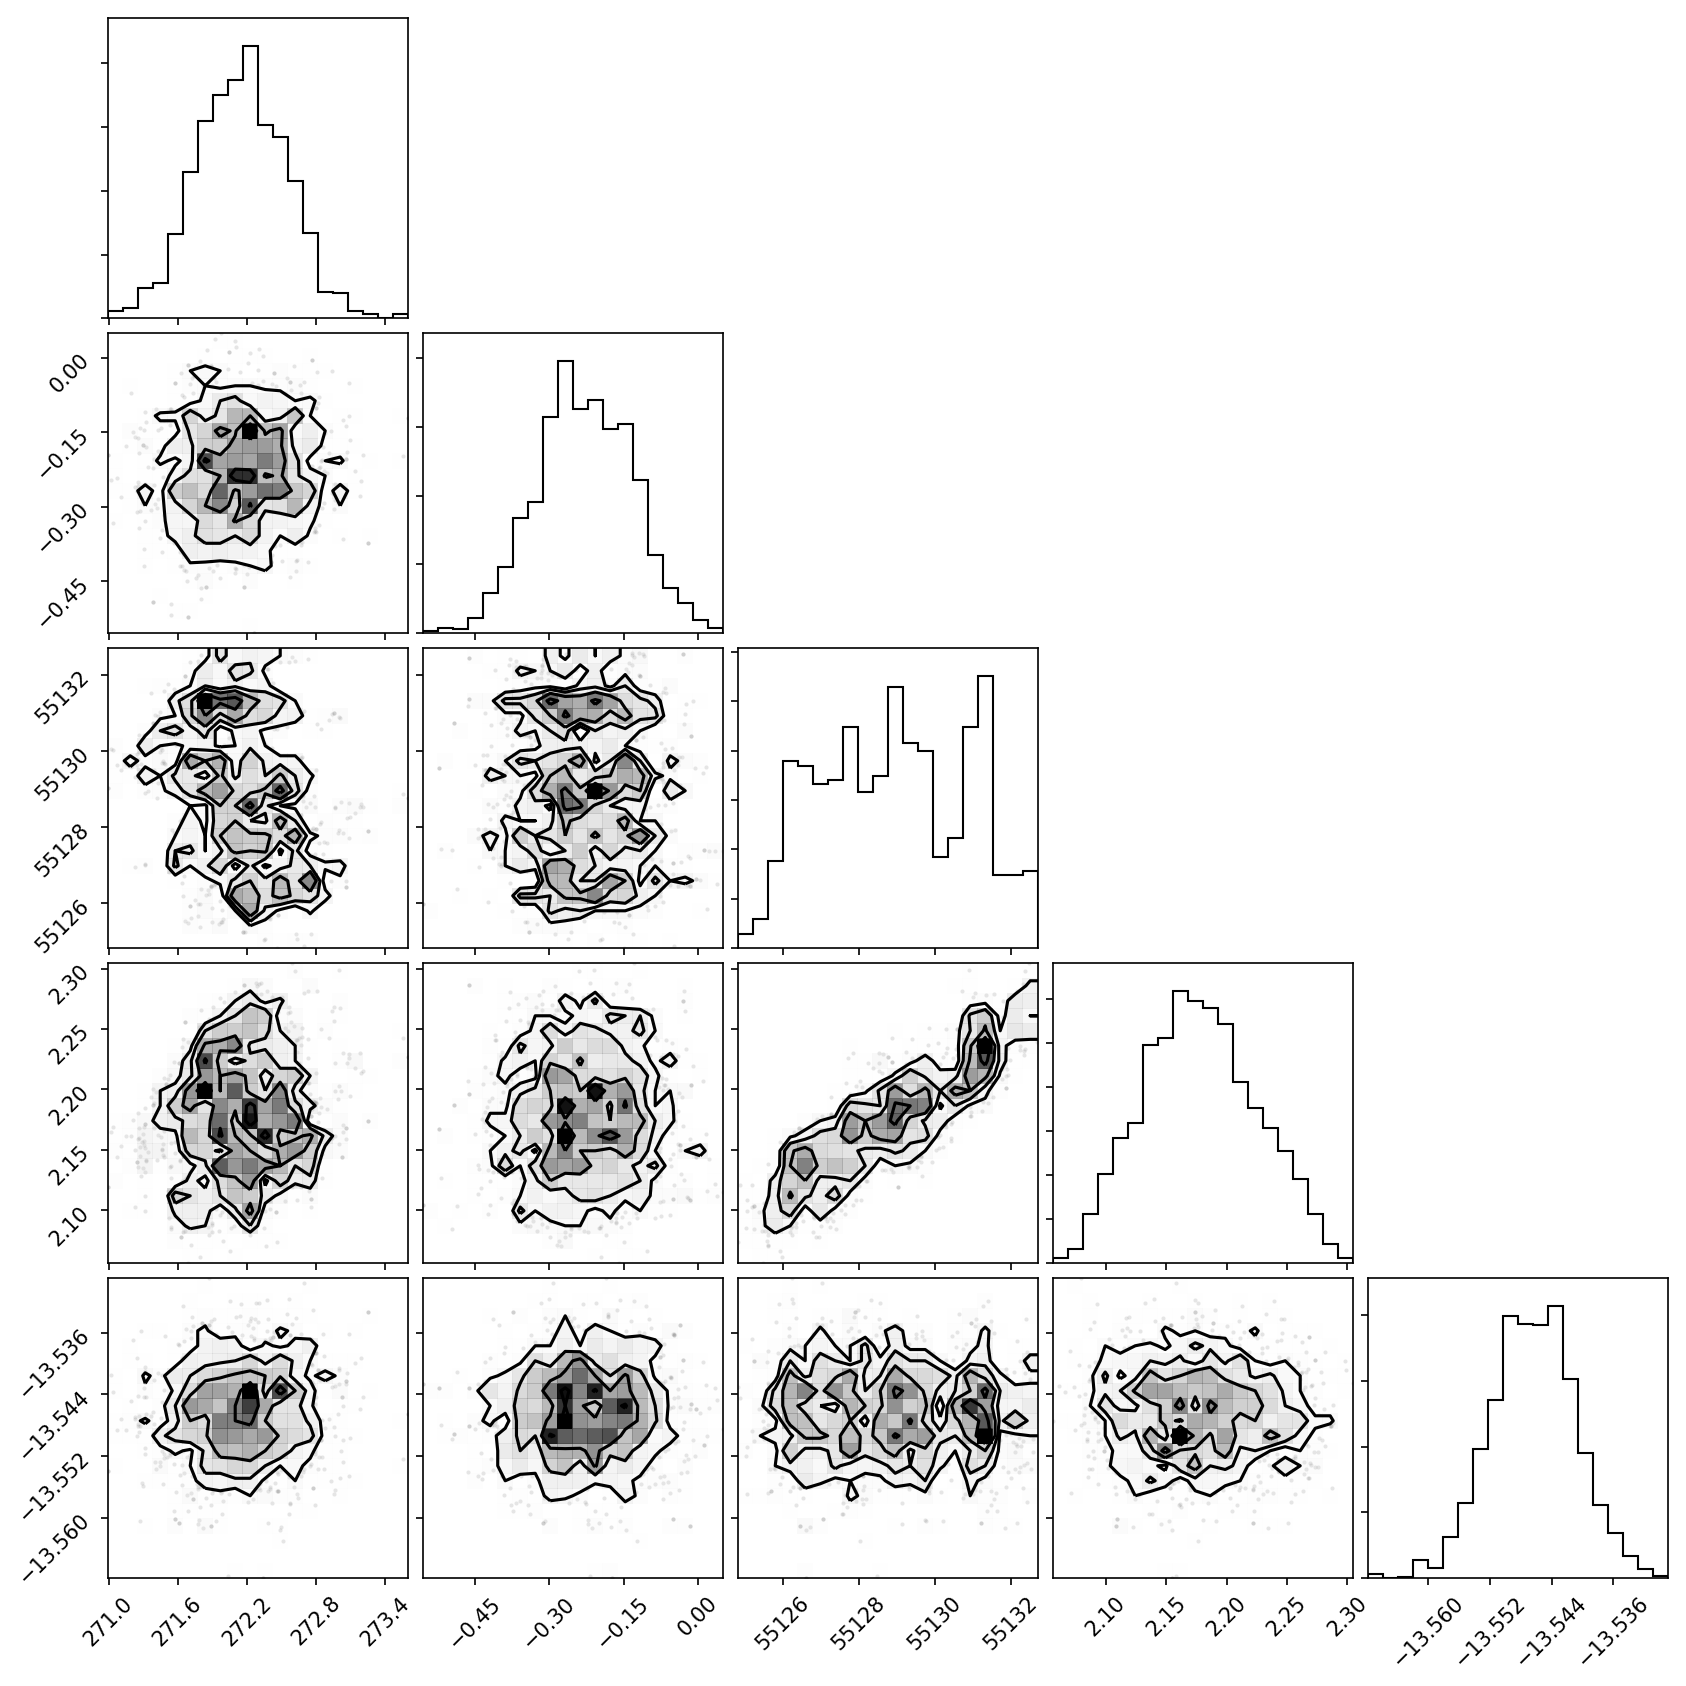

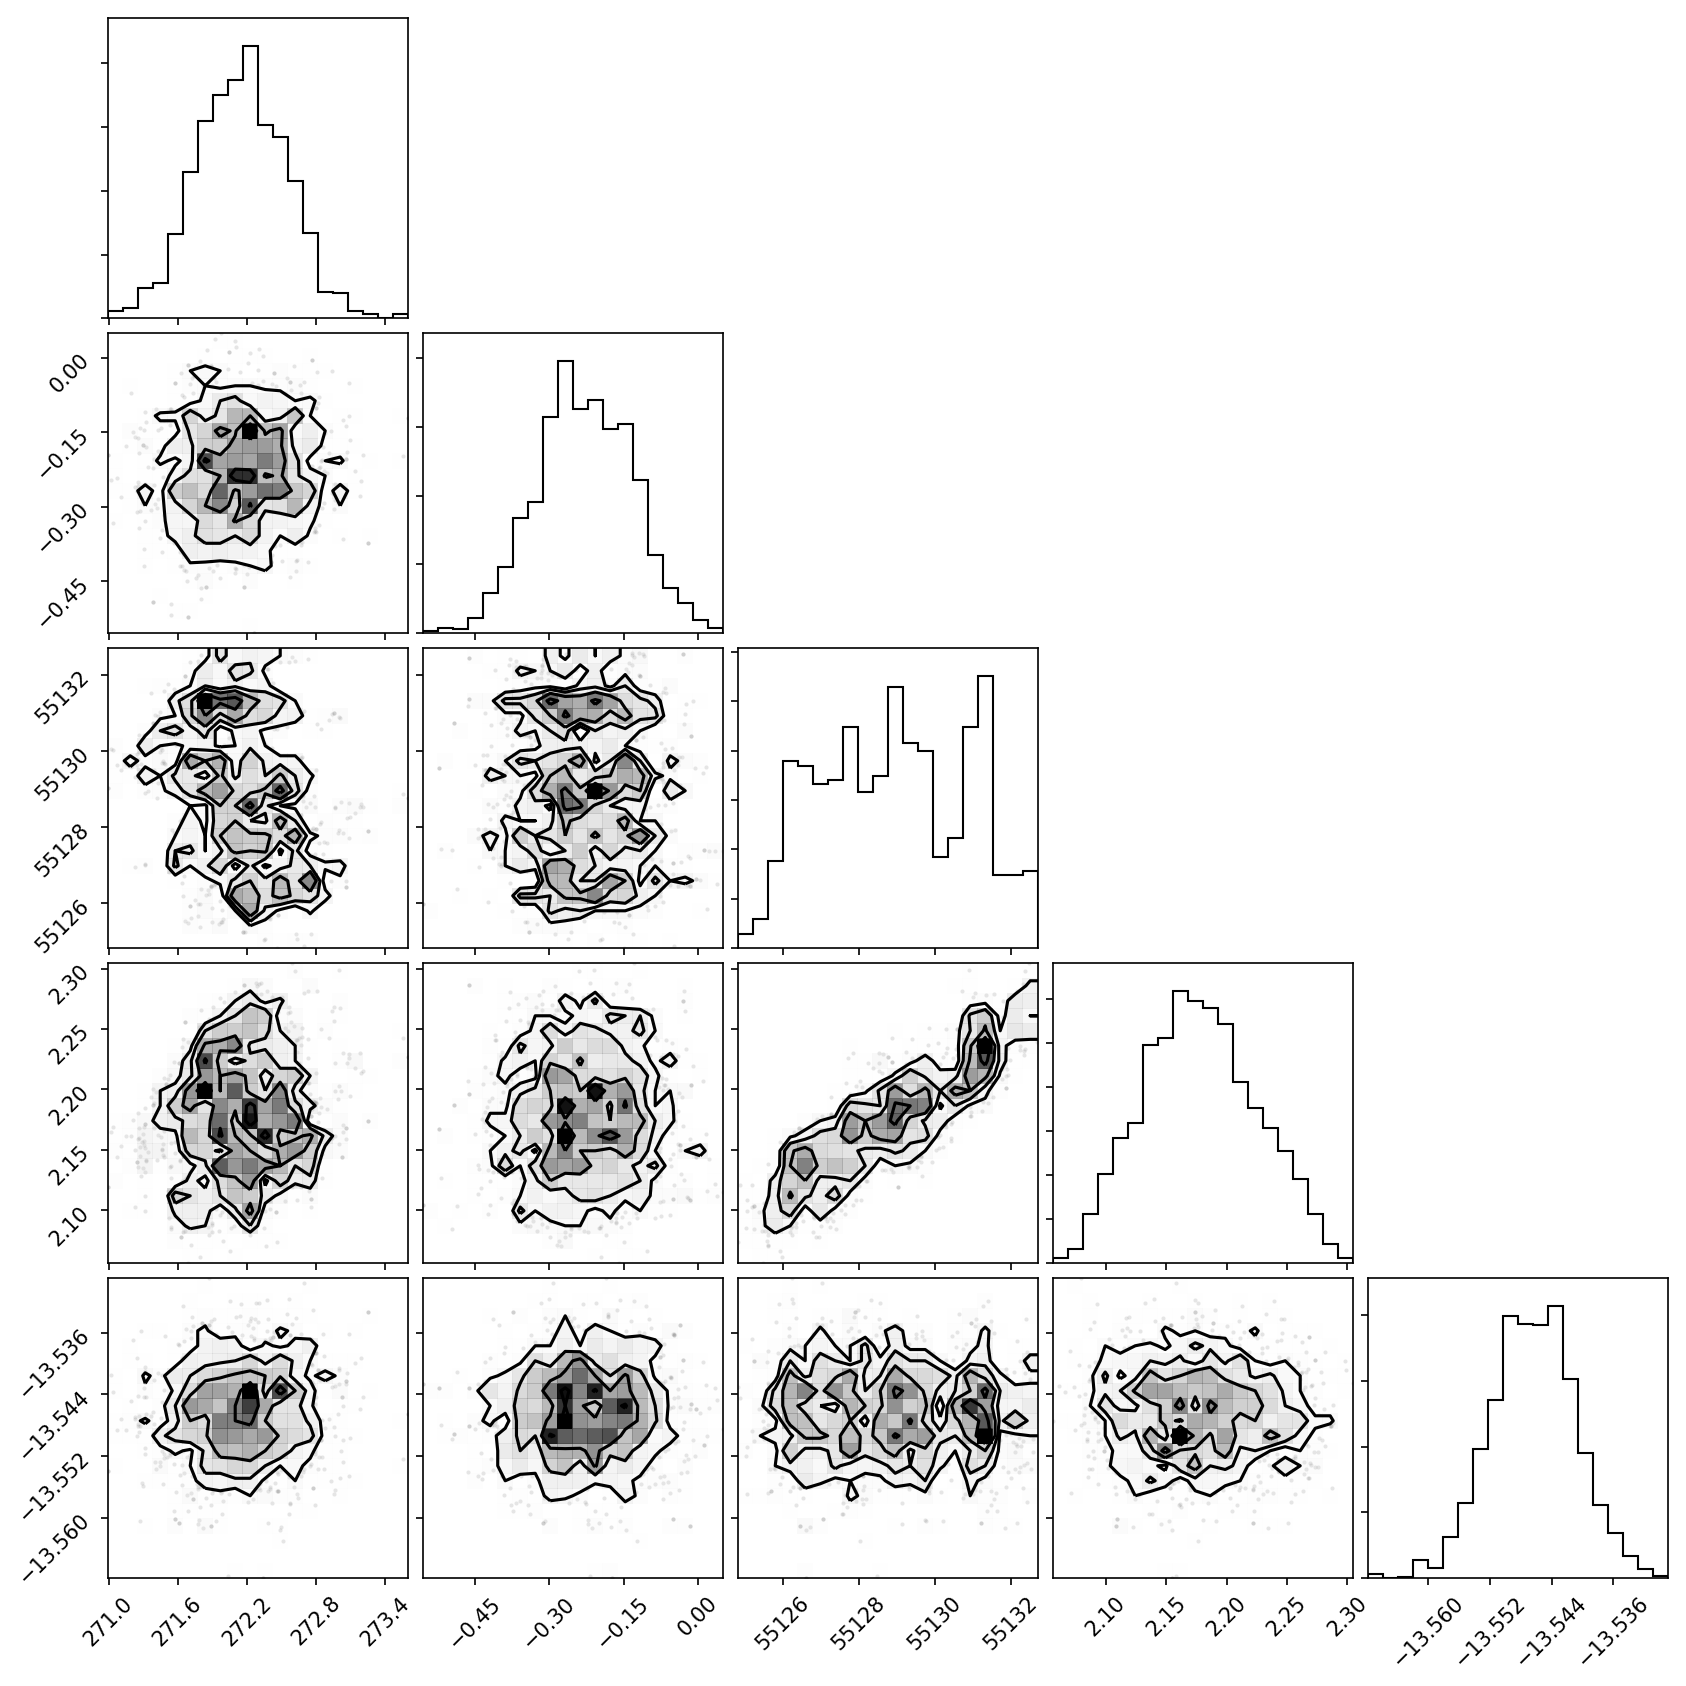

In [19]:
corner.corner(model.chain[0])

dashy cray

Check out what happens when I try to run the lighttime tensor through Hemcee

In [20]:
model.params = [model.lighttime]
model.run_warmup(1000)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 3 into shape (9,)

I've tried a few different things to get it working, and you'll probably see the remnants of them lying around in the source code. My most recent attempt was to pack all the params into a single rank 1 tensor:

In [21]:
model.params = [model._pack(model.params)]

In [22]:
model.run_mcmc(samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: Fetch argument None has invalid type <class 'NoneType'>

### PB2 

Although the lighttime tensor works fine with PB2/PB1/SB1 systems, it fails on SB2 systems. This is because both radial velocity `vrad` attribs share the same `lighttime` tensor. So when scipy, or anything else tries to optimize, it picks lighttime values that are almost exactly halfway between `a1` and `a2`. Is this because I haven't parametrised it properly? Here's a good example of it below:

In [23]:
kic_id = 5709664 # PB2 system

# Load in the lightcurve and frequencies
times, mags = np.loadtxt(f"data/kic{kic_id}_lc.txt",usecols=(0,1)).T
nu_arr = np.loadtxt(f"data/kic{kic_id}_metadata.csv", delimiter=",", skiprows=1)[::6]

# Get the RV data
rvs = []
for i in 'ab':
    rvs.append(ms.maelstrom.RadialVelocity(*np.loadtxt(f"data/kic{kic_id}"+i+"_JDrv.txt", delimiter=",", usecols=(0,1,2)).T, meta=i))

# Previously known values
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
orb_params = orbits[orbits.Name == f"kic{kic_id}"].iloc[0]
porb = orb_params.Porb
a1 = orb_params["a1sini/c"] 
tp = orb_params["t_p"]
e = orb_params["e"]
varpi = orb_params["varpi"]
a1d = a1/86400.0

In [24]:
# Check both sets of RV data separately:
for rv in rvs:
    model = ms.Maelstrom(times, mags, nu=nu_arr,rvs=[rv])

    # Set lighttime to 0 so no preference, everything else is fixed to their known values
    model.init_from_orbit(period=porb, lighttime=0, tref=tp, eccen=e, varpi=varpi)

    # Optimize:
    model.optimize([model.lighttime])

    # Output
    print(model.rvs[0].meta, model.pin_lighttime_values()[1])

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 28066.501510
  Number of iterations: 2
  Number of functions evaluations: 4
a [0.00076417]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 30047.114901
  Number of iterations: 2
  Number of functions evaluations: 4
b [-0.00165313]


In [25]:
# Now, both at once
model = ms.Maelstrom(times, mags, nu=nu_arr, rvs=rvs)
model.init_from_orbit(period=porb, lighttime=0, tref=tp, eccen=e, varpi=varpi)

# Optimize
model.optimize([model.lighttime])

model.pin_lighttime_values()[1]

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 92424.232337
  Number of iterations: 2
  Number of functions evaluations: 4


array([-0.00044924])

In [26]:
(0.00076417 + -0.00165313) / 2

-0.00044448

Note: the same thing happens if all the RV data is fed in as a single array, without discriminating between `a` and `b`